Importing the necessary libraries

In [66]:
import os
import zipfile
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from kerastuner.tuners import RandomSearch

In [27]:
# Task 1 - Data Collection
zip_ref = zipfile.ZipFile('Dataset.zip', 'r')
zip_ref.extractall('Dataset')
zip_ref.close()

 Task 1 - Data Collection

In [28]:
def load_images_from_folder(folder):
    images = []
    labels = []  # 0 for 'real', 1 for 'fake'
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, (64, 64))  # Resize images
            images.append(img)
            if 'real' in folder:
                labels.append(0)
            else:
                labels.append(1)
    return images, labels

In [29]:
# Load 'real' and 'fake' images
real_images, real_labels = load_images_from_folder('Dataset/real')
fake_images, fake_labels = load_images_from_folder('Dataset/fake')

In [30]:
# Combine and convert to numpy arrays
X = np.array(real_images + fake_images)
y = np.array(real_labels + fake_labels)

In [31]:
# Task 2 - Data Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

Task3 - model creation and training

In [47]:
def build_model(hp):
    model = Sequential([
        Conv2D(hp.Int('conv1_units', min_value=32, max_value=128, step=16), (3, 3), activation='relu', input_shape=(64, 64, 3)),
        MaxPooling2D(2, 2),
        Conv2D(hp.Int('conv2_units', min_value=32, max_value=128, step=16), (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(hp.Int('dense_units', min_value=64, max_value=512, step=64), activation='relu'),
        Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

Hyper Parameter Tuning

In [50]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=2,  # Adjust as needed
    executions_per_trial=1,  # Adjust as needed
    directory='hyperparameter_tuning',
    project_name='deepfake_detection'
)

Reloading Tuner from hyperparameter_tuning/deepfake_detection/tuner0.json


In [51]:
tuner.search(train_generator, epochs=10, validation_data=val_generator)

Trial 2 Complete [00h 06m 30s]
val_accuracy: 0.5670498013496399

Best val_accuracy So Far: 0.5708812177181244
Total elapsed time: 00h 24m 03s


In [53]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [54]:
# Build the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 62, 62, 48)        1344      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 31, 31, 48)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 29, 29, 128)       55424     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 14, 14, 128)       0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 448)              

Task 4 - mOdel creation and training

In [56]:
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

In [57]:
# Train the model with the best hyperparameters
history = model.fit(train_generator, steps_per_epoch=len(X_train) // 32, epochs=10, validation_data=val_generator, validation_steps=len(X_val) // 32)

Epoch 1/10
46/46 [==============================] - 37s 801ms/step - loss: 0.6931 - accuracy: 0.5205 - val_loss: 0.6889 - val_accuracy: 0.5664
Epoch 2/10
46/46 [==============================] - 29s 636ms/step - loss: 0.6927 - accuracy: 0.5219 - val_loss: 0.6858 - val_accuracy: 0.5703
Epoch 3/10
46/46 [==============================] - 30s 651ms/step - loss: 0.6940 - accuracy: 0.5108 - val_loss: 0.6872 - val_accuracy: 0.5664
Epoch 4/10
46/46 [==============================] - 33s 717ms/step - loss: 0.6928 - accuracy: 0.5232 - val_loss: 0.6880 - val_accuracy: 0.5742
Epoch 5/10
46/46 [==============================] - 29s 623ms/step - loss: 0.6922 - accuracy: 0.5219 - val_loss: 0.6881 - val_accuracy: 0.5742
Epoch 6/10
46/46 [==============================] - 30s 646ms/step - loss: 0.6924 - accuracy: 0.5226 - val_loss: 0.6895 - val_accuracy: 0.5625
Epoch 7/10
46/46 [==============================] - 30s 647ms/step - loss: 0.6922 - accuracy: 0.5239 - val_loss: 0.6904 - val_accuracy: 0.5508

Task5 - Evaluating the model

In [58]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow(X_test, y_test, batch_size=32)
eval_result = model.evaluate(test_generator)
print(f"\nTest Loss: {eval_result[0]}, Test Accuracy: {eval_result[1]}")

10/10 [==============================] - 1s 136ms/step - loss: 0.6920 - accuracy: 0.5309

Test Loss: 0.6919940114021301, Test Accuracy: 0.5309446454048157


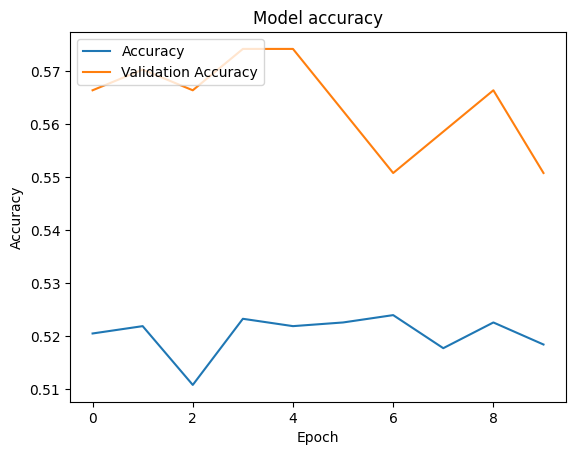

In [59]:
# Plotting the training and validation accuracy
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

Testing

In [60]:
import matplotlib.pyplot as plt

In [61]:
# Function to plot images along with their predictions
def plot_images(images, labels, predictions):
    n = 10  # Number of images to display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(images[i])
        plt.title(f"Actual: {'Real' if labels[i] == 0 else 'Fake'}")
        plt.suptitle(f"Predicted: {'Real' if predictions[i] < 0.5 else 'Fake'}")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [62]:
# Predicting on the test set
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow(X_test, y_test, batch_size=32, shuffle=False)

In [63]:
predictions = model.predict(test_generator, steps=len(X_test) // 32 + 1)
# Convert predictions to binary (0 or 1)
binary_predictions = [1 if pred > 0.5 else 0 for pred in predictions]

10/10 [==============================] - 1s 100ms/step


In [64]:
# Select a subset of images to display
images_to_show = X_test[:10]
actual_labels = y_test[:10]

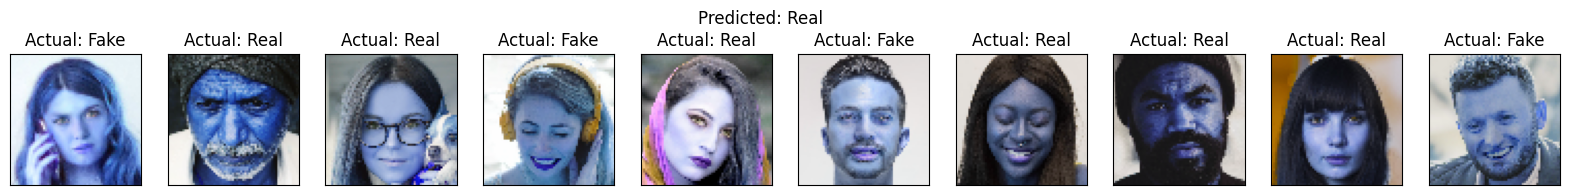

In [65]:
# Call the function to plot images with predictions
plot_images(images_to_show, actual_labels, binary_predictions)